# Energy method

This notebook aims at evaluating the **Energy method**.

The method consists in using the energy of the input data computed using the energy

$$ 
-\log \sum_{c=0}^C \exp(l_c)
$$

computed using the logits $l_c$ such that $model(x)=(l_{c})_{c=1}^{C}$.

This notebook quickly showcase Energy on MNIST vs Fashion MNIST.

**Reference**
[Energy-based Out-of-distribution Detection](http://arxiv.org/abs/2010.03759), Neurips 2020. 

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" 

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from oodeel.methods import Energy
from oodeel.eval.metrics import bench_metrics
from oodeel.datasets import OODDataset
from oodeel.models.training_funs import train_convnet_classifier_torch

from sklearn.metrics import *

import warnings
warnings.filterwarnings("ignore")


Note that models are saved at *~/.oodeel/saved_models* by default. Change the following cell for a custom path.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = os.path.expanduser("~/") + ".oodeel/saved_models"
data_path = os.path.expanduser("~/") + ".oodeel/datasets"
os.makedirs(model_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

/!\ We denote In-Distribution (ID) data with `_in` and Out-Of-Distribution (OOD) data with `_out` to avoid confusion with OOD detection which is the name of the task, and is therefore used to denote core classes such as `OODDataset` and `OODModel`.

In [3]:
oods_in = OODDataset('MNIST', split="test", backend="torch", load_kwargs={"root": data_path, "download": True})
oods_out = OODDataset('FashionMNIST', split="test", backend="torch", load_kwargs={"root": data_path, "download": True})
oods_train = OODDataset('MNIST', split="train", backend="torch", load_kwargs={"root": data_path, "download": True})

batch_size = 128
# Note: no peprocess_fn is required since torchvision datasets are already normalized
ds_in = oods_in.prepare(batch_size=batch_size, preprocess_fn=None)
ds_out = oods_out.prepare(batch_size=batch_size, preprocess_fn=None)
ds_train = oods_train.prepare(batch_size=batch_size, preprocess_fn=None, shuffle=True)

Train or load a model on in-distribution data (MNIST).

In [4]:
model_path_mnist = os.path.join(model_path, "mnist_model")

try:
    model = torch.load(os.path.join(model_path_mnist, "best.pt"))
    
except OSError:
    train_config = {
        "input_shape": (1, 28, 28),
        "num_classes": 10,
        "batch_size": 128,
        "is_prepared": True,
        "epochs": 5,
        "save_dir": model_path_mnist,
        "validation_data": ds_in #ds_in is actually the test set of MNIST
    }

    model = train_convnet_classifier_torch(ds_train, **train_config) #ds_train is actually the train set of MNIST

model.eval()
model = model.to(device)

Fit `OODModel` to the model at hand

In [5]:
oodmodel = Energy()
oodmodel.fit(model)

Then compute the scores for in-distribution and out-of-distribution data. Also display some visualizations.

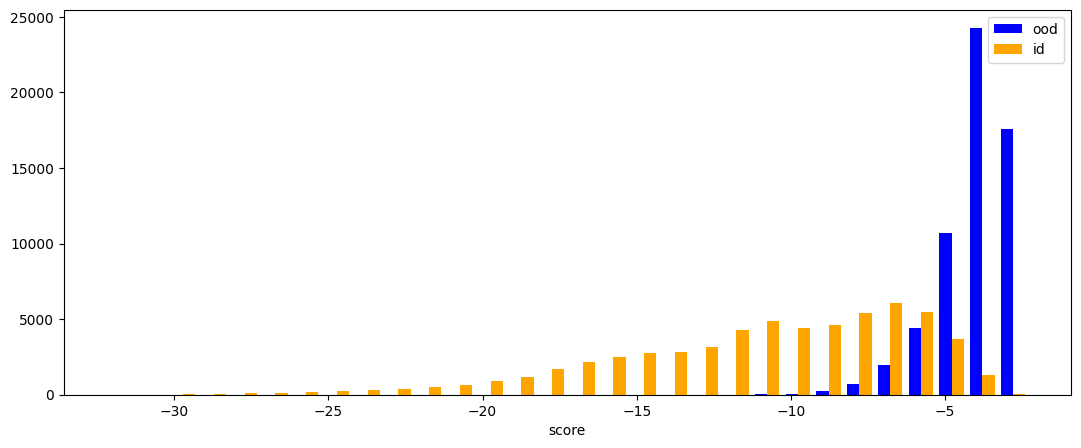

auroc       0.966300
fpr95tpr    0.178083
Name: mnist-10-vs-fashion, dtype: float64


In [6]:
scores_in = oodmodel.score(ds_in)
scores_out = oodmodel.score(ds_out)


metrics = bench_metrics(
    (scores_in, scores_out),  
    metrics = ["auroc", "fpr95tpr"], 
    )


# plot hists / roc
def plot_hist(scores_in, scores_out, bins, log=False):
    if log:
        minim = np.min([np.min(scores_in), np.min(scores_out)])
        scores_in_ = scores_in - 2 * minim + np.min(scores_in[np.where(scores_in != minim)])
        scores_out_ = scores_out - 2 * minim + np.min(scores_in[np.where(scores_in != minim)])
        _, bins = np.histogram(np.concatenate([scores_in_, scores_out_]), bins=30)
        logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
        plt.xscale('log')
        plt.xlabel("score (normalized log axis)")
    else:
        logbins=bins
        scores_in_ = scores_in 
        scores_out_ = scores_out
        plt.xlabel("score")
    plt.hist((scores_out_, scores_in_), bins=logbins, color=("blue", "orange"), label=("ood", "id"))
    plt.legend()
    plt.show()

plt.figure(figsize=(13, 5))
plot_hist(scores_in, scores_out, 30)
metrics_fashion = pd.Series(metrics, name='mnist-10-vs-fashion')
print(metrics_fashion)